In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [3]:
# Cats-v-Dogs dataset 다운로드  , cats-and-dogs.zip 으로 저장
# tmp 파일에 압출 풀면 tmp/PetImages directory에  'Cat' , 'Dog' 하위 디렉토리가 있음
# 작동하지 않으면 사이트를 이용해서 직접 다운로드 : https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-10-07 14:55:26--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1409:12:285::e59, 2600:1409:12:2af::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   224MB/s    in 3.5s    

2020-10-07 14:55:30 (223 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))#12501
print(len(os.listdir('/tmp/PetImages/Dog/')))#12501

12501
12501


In [5]:
#  os.mkdir 이용해서 directory 생성 
# 구조 :  cats-v-dogs/training or testing /cats or dogs

try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')

    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

[링크 텍스트](https://)

In [6]:
# 디렉토리에서  주어진 사이즈에 따라서 train, test 나눔
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
'''   a SOURCE directory containing the files
      a TRAINING directory that a portion of the files will be copied to
      a TESTING directory that a portion of the files will be copie to
      a SPLIT SIZE to determine the portion'''

    files = []
    #해당 디렉토리의 내부를 listing
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        # 디렉토리 내의 file 사이즈 0이면 제외시킴
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files)) 
    #split
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]
# 파일을 카피해서 붙여넣기
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
###  train:test = 9:1로 분할


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"

TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# 길이 0데이터 제외 : 666.jpg 11702.jpg are zero length, so ignoring

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [7]:
#train:test per category 11250:1250 
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/'))) #11250
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/'))) #11250
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))  #1250
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [8]:
# 3개의 convolutoin +pooling layers 이용한 binary classificaiton

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"

#파라미터 변경해보기~~
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22499 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [10]:
history = model.fit(train_generator,epochs=15,  verbose=1,
                    validation_data=validation_generator)

# The expectation here is that the model will train, and that accuracy will be > 95% on both training and validation
# i.e. acc:A1 and val_acc:A2 will be visible, and both A1 and A2 will be > .9

Epoch 1/15
150/225 [===================>..........] - ETA: 58s - loss: 0.8486 - accuracy: 0.5575

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 196s 873ms/step - loss: 0.7922 - accuracy: 0.5734 - val_loss: 0.6527 - val_accuracy: 0.6380
Epoch 2/15
225/225 [==============================] - 192s 854ms/step - loss: 0.6348 - accuracy: 0.6500 - val_loss: 0.6099 - val_accuracy: 0.6604
Epoch 3/15
225/225 [==============================] - 193s 858ms/step - loss: 0.5949 - accuracy: 0.6875 - val_loss: 0.5552 - val_accuracy: 0.7196
Epoch 4/15
225/225 [==============================] - 193s 858ms/step - loss: 0.5589 - accuracy: 0.7152 - val_loss: 0.5400 - val_accuracy: 0.7240
Epoch 5/15
225/225 [==============================] - 187s 832ms/step - loss: 0.5423 - accuracy: 0.7266 - val_loss: 0.5216 - val_accuracy: 0.7388
Epoch 6/15
225/225 [==============================] - 183s 814ms/step - loss: 0.5244 - accuracy: 0.7399 - val_loss: 0.5223 - val_accuracy: 0.7476
Epoch 7/15
225/225 [==============================] - 177s 787ms/step - loss: 0.5094 - accuracy: 0.7497 - val_loss: 0.4966 - val_accura

Text(0.5, 1.0, 'Training and validation loss')

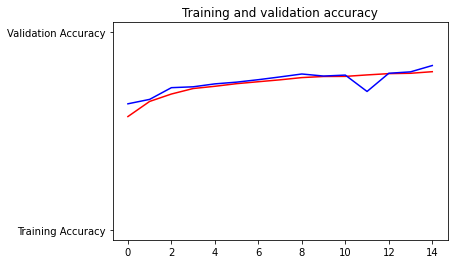

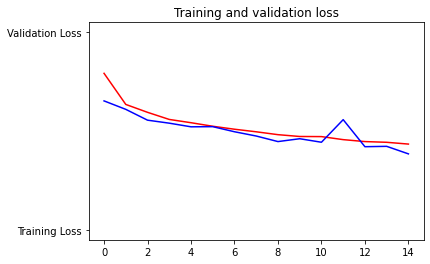

In [11]:
#  LOSS & ACCURACY 시각화
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training & test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) #epoch 횟수

#train & validation accuracy, loss 그리기
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

 
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

In [16]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " 개 입니다")
  else:
    print(fn + " 고양이 입니다")

Saving aa.jpeg to aa.jpeg
[1.]
aa.jpeg 개 입니다
